# Bayesian Optimization Tutorial: 1-dimensional Bayesian optimization using GP lower confidence bound acquisition function   
**By Wenjie Xu**

Throughout this tutorial, you will see blocks of code. In some of the places, they contain a block of code like:
```python
## Edit here.
...
## Stop editing here. 
```

These indicate the part of code with different parameters, so that you can experiment with changing parameters. Remember that these hyperparameters may have far-reaching effects on the whole tutorial!  

### Introduction
For this tutorial, we will attempt to find the global minima of the Ackley function $$f(x)=(-20e^{-0.2|x|}-e^{\cos(2\pi x)}+20+e)$$ in the domain $x \in [-30,30]$.

The two main components of Bayesian optimization are:
1. A surrogate model for approximating the black-box objective function $f(x)$.
2. An "acqusition function" $q(x)$ that informs us of the value in samping the new point $x$ for optimization purpose.


In [1]:
## Be sure to run this cell first to import the relied packages 

## Installing relevant packages by uncommenting the following line
# !pip install GPy scipy numpy matplotlib ipython

import GPy
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(40)

%matplotlib inline
%reload_ext autoreload
%autoreload 2


## Learning the black-box function $f(x)$ with a Gaussian Process

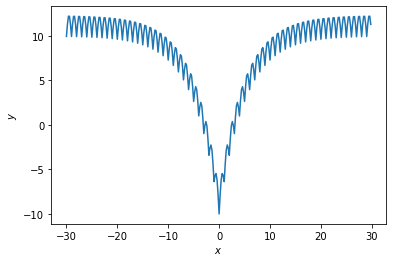

In [2]:
## Edit here.
y_shift = -10
noise_level = 1e-2
def f(x):
    """The function to be optimized."""
    return -20 * np.exp(- 0.2 * np.abs(x)) - np.exp(np.cos(2 * np.math.pi * x)) + 20 + np.exp(1) + y_shift + noise_level * np.random.randn()
x_bound = (-30, 30)
## Stop editing here.

## Plot the function
fig = plt.figure()
ax = fig.gca()
x_step = 0.2
x_arr = np.arange(x_bound[0], x_bound[1], x_step)
y_arr = f(x_arr)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

plt.plot(x_arr, y_arr)
plt.show()

It is clear that the global minima is at around $x=0.0$, but there are lots of 'adversarial' minima distributed in the whole input domain. 

To learn the function with a Gaussian Process, we first choose its hyperparameters.

For the convenience of demonstration, we use the Squared Exponential (RBF) kernel as our covariance, and a zero mean. For the kernel, we manually set the lengthscale to be $2.0$, kernel variance as $5$ and noise standard deviation as $0.05$.


# define the Gaussian process

(-30.0, 30.0)

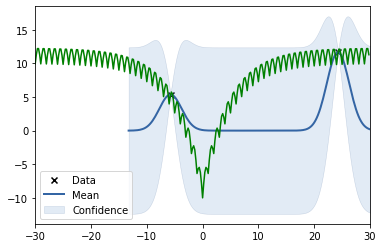

In [28]:
## Edit here!
length_scale = 2.0
sigma_noise = 5e-2
prior_mean = 0.0
fun_var = 40.0
num_random_init = 2
## Stop editing here.

# Set the kernel for the Gaussian process
kernel = GPy.kern.RBF(input_dim=1, 
                      variance=fun_var,
                      lengthscale=length_scale,
                      ARD=True
                     )

# pick several randomly sampled points to initialize the GP
init_X = x_bound[0] + np.random.rand(num_random_init) * (x_bound[1] - x_bound[0]) 
init_Y = f(init_X)

np.int = np.int32
obj_gp = GPy.models.GPRegression(
    np.expand_dims(init_X, axis=1),
    np.expand_dims(init_Y, axis=1),
    kernel,
    noise_var = sigma_noise ** 2
)

fig, ax = plt.subplots() 

obj_gp.plot(ax=ax)

ax.plot(x_arr, y_arr, color='g')
ax.set_xlim(x_bound)

Optimizing GP hyperparameters by fitting to the data.

## The Acquisition Function

### Lower Confidence Bound $q_\text{LCB}$

A simple and principled acquisition function that balances exploitation/exploration well is the lower confidence bound. This is an optimistic estimate of the function value at a new location, which can guide our search of the global optimum.

\begin{equation}
q_\text{LCB}(x) = \mu_t(x) - \beta_t\sigma_t(x), 
\end{equation}
where $\mu_t$ is the posterior mean, $\sigma_t$ is the posterior standard deviation, and $\beta_t$ is a coefficient that captures the exploration level. Intuitively, the more complex the black-box function is, the larger $\beta_t$ should be set.  

(-30.0, 30.0)

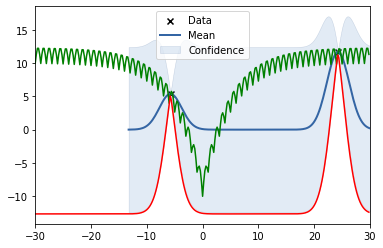

In [29]:
# the function qLCB() computes and returns the lower confidence bound value  
def qLCB(gp, x, beta=2.0):
    mean, var = gp.predict(x)
    lcb = mean - beta * np.sqrt(var)
    return lcb

lcb = qLCB(obj_gp, np.expand_dims(x_arr, axis=1))


fig, ax = plt.subplots() 

obj_gp.plot(ax=ax)

ax.plot(x_arr, y_arr, color='g')
ax.plot(x_arr, lcb, color='r')
ax.set_xlim(x_bound)


# Run Bayesian Optimization in a closed loop

In [30]:
run_num = 10

# define the function that optimizes the acquisition function
def get_next_point(gp, x_arr):
    qLCB_arr = qLCB(gp, x_arr)
    qLCB_arr = np.squeeze(qLCB_arr)
    next_point_id = np.argmin(qLCB_arr)
    return x_arr[next_point_id]

## Do the iterate.

New sample point: [-30.].
New sample point: [9.2].
New sample point: [-17.8].
New sample point: [1.6].
New sample point: [16.6].
New sample point: [-11.6].
New sample point: [-24.].
New sample point: [29.8].
New sample point: [-1.4].
New sample point: [4.6].


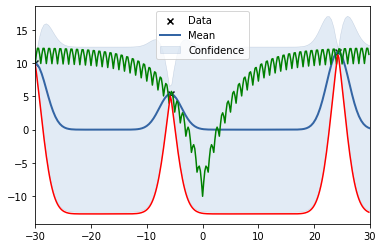

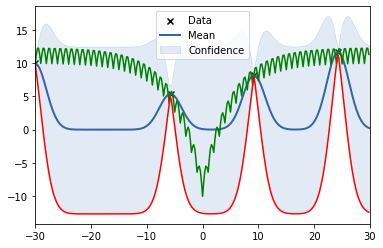

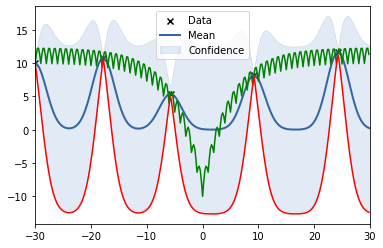

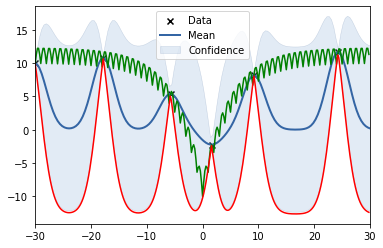

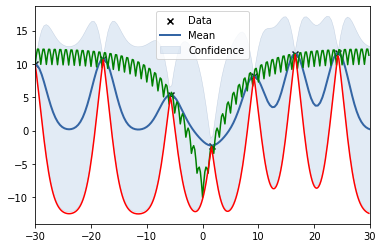

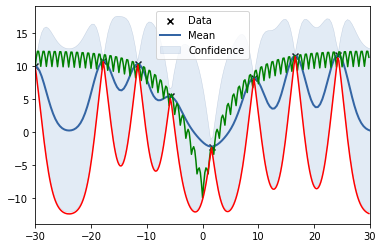

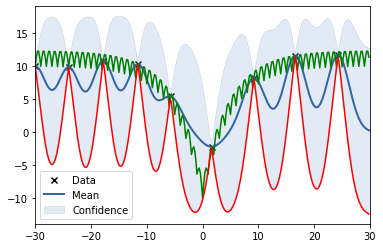

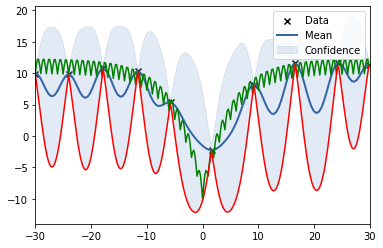

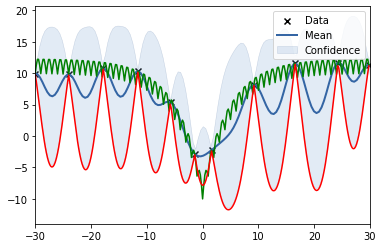

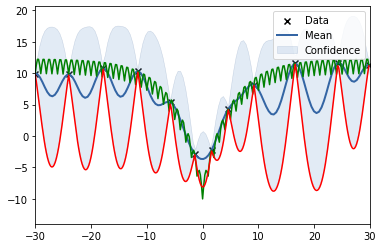

In [31]:
simple_regret_list = []  # track the evolution of simple regret, which is defined as the minimum objective value sampled so far minus the ground truth optimal value
ground_truth_min_val = np.min(y_arr)  # stores the ground truth minimum value to compute the regret

for i in range(run_num):
    next_point = get_next_point(obj_gp, np.expand_dims(x_arr, axis=1)) # get the next point 
    print(f'New sample point: {next_point}.')
    new_f_val = f(next_point) 
    
    new_X = np.concatenate((obj_gp.X, np.atleast_2d(next_point)))
    new_Y = np.concatenate((obj_gp.Y, np.atleast_2d(new_f_val)))
    obj_gp.set_XY(new_X, new_Y)
    
    best_val = np.min(new_Y)
    simple_regret = best_val - ground_truth_min_val
    simple_regret_list.append(simple_regret)
    
    # plot the new result
    lcb = qLCB(obj_gp, np.expand_dims(x_arr, axis=1))
    fig, ax = plt.subplots() 

    obj_gp.plot(ax=ax)
    ax.plot(x_arr, y_arr, color='g')
    ax.plot(x_arr, lcb, color='r')
    ax.set_xlim(x_bound)

    

## Plot the evolution of simple regret, which is defined as,
$$
r_t=\min_{\tau\in[t]}f(x_\tau)-f(x^\star).
$$

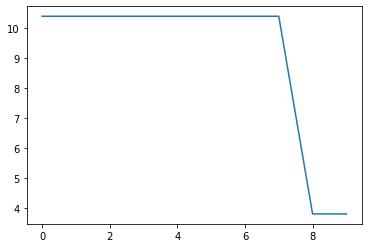

In [15]:
plt.plot(simple_regret_list)